In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import *
import numpy as np
%matplotlib inline

## Подготовка и визуализация данных

In [ ]:
train_loader, valid_loader, test_loader = mnist(valid=10000, batch_size=50)

In [ ]:
images = mnist_plotdata()
plot_mnist(images, (5, 10))

## Обучение классификатора

In [ ]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(256)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)    
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [ ]:
def train(epoch, models):
    loss_stats = np.empty((0,4))
    
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
       
        for model in models:
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()                
            
            
        if batch_idx % 200 == 0:
            print_stats(models, train_loader, epoch, batch_idx, data, train_size)            
            stats_line = np.array([m._loss.item() for m in models])
            loss_stats = np.vstack([loss_stats, stats_line])          
            
    else:
        batch_idx += 1
        print_stats(models, train_loader, epoch, batch_idx, data, train_size)
        stats_line = np.array([m._loss.item() for m in models])
        loss_stats = np.vstack([loss_stats, stats_line])
       
    epoch_loss = np.mean(loss_stats, axis=0)      
    return epoch_loss
       
        
def print_stats(models, train_loader, epoch, batch_idx, data, train_size):
    line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
    losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in enumerate(models)])
    print(line + losses)
        

In [ ]:
models = [Net(False, False), Net(True, False), Net(False, True), Net(True, True)]

In [7]:
def test(models, loader):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = [0]*len(models)
    correct = [0]*len(models)
    with torch.no_grad():
        for data, target in loader:
            output = [m(data) for m in models]
            for i, m in enumerate(models):
                test_loss[i] += m.loss(output[i], target, size_average=False).item() # sum up batch loss
                pred = output[i].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[i] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for i in range(len(models)):
        test_loss[i] /= test_size
    correct_pct = [100. * c / test_size for c in correct]
    lines = '\n'.join([line(i, test_loss[i], correct[i], correct_pct[i]) for i in range(len(models))]) + '\n'
    report = 'Test set:\n' + lines
    
    print(report)
    
    return test_loss, correct_pct

In [19]:
epoch_train_loss = []
epoch_test_loss = []
epoch_test_acc = []

In [20]:
for epoch in range(1, 21):
    for model in models:
        model.train()
    train_loss_val = train(epoch, models)
    epoch_train_loss.append(train_loss_val)
    
    for model in models:
        model.eval()
    test_loss_val, test_acc_val = test(models, valid_loader)
    epoch_test_loss.append(test_loss_val)
    epoch_test_acc.append(test_acc_val)
    

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/50000 (0%)]	Losses 0: 2.327425 1: 2.340549 2: 2.296613 3: 2.290284
Train Epoch: 1 [10000/50000 (20%)]	Losses 0: 0.528703 1: 0.646311 2: 0.522253 3: 0.682473
Train Epoch: 1 [20000/50000 (40%)]	Losses 0: 0.300755 1: 0.297055 2: 0.292518 3: 0.301515
Train Epoch: 1 [30000/50000 (60%)]	Losses 0: 0.491225 1: 0.382450 2: 0.479021 3: 0.388505
Train Epoch: 1 [40000/50000 (80%)]	Losses 0: 0.388524 1: 0.344619 2: 0.382316 3: 0.344652
Train Epoch: 1 [50000/50000 (100%)]	Losses 0: 0.210931 1: 0.185536 2: 0.231152 3: 0.204111
Test set:
0: Loss: 0.2578	Accuracy: 9232/10000 (92%)
1: Loss: 0.1998	Accuracy: 9418/10000 (94%)
2: Loss: 0.2527	Accuracy: 9243/10000 (92%)
3: Loss: 0.2102	Accuracy: 9383/10000 (93%)

Train Epoch: 2 [0/50000 (0%)]	Losses 0: 0.446509 1: 0.342857 2: 0.428970 3: 0.378852
Train Epoch: 2 [10000/50000 (20%)]	Losses 0: 0.185910 1: 0.140166 2: 0.172756 3: 0.162060
Train Epoch: 2 [20000/50000 (40%)]	Losses 0: 0.229983 1: 0.189725 2: 0.207024 3: 0.226461
Train Epoch: 2 [

Train Epoch: 12 [40000/50000 (80%)]	Losses 0: 0.075219 1: 0.045865 2: 0.056565 3: 0.055696
Train Epoch: 12 [50000/50000 (100%)]	Losses 0: 0.082602 1: 0.057633 2: 0.064620 3: 0.040889
Test set:
0: Loss: 0.0919	Accuracy: 9732/10000 (97%)
1: Loss: 0.0803	Accuracy: 9795/10000 (97%)
2: Loss: 0.0849	Accuracy: 9761/10000 (97%)
3: Loss: 0.0788	Accuracy: 9784/10000 (97%)

Train Epoch: 13 [0/50000 (0%)]	Losses 0: 0.049020 1: 0.014964 2: 0.047294 3: 0.018037
Train Epoch: 13 [10000/50000 (20%)]	Losses 0: 0.042093 1: 0.008380 2: 0.030662 3: 0.009727
Train Epoch: 13 [20000/50000 (40%)]	Losses 0: 0.012305 1: 0.002360 2: 0.006216 3: 0.011906
Train Epoch: 13 [30000/50000 (60%)]	Losses 0: 0.069471 1: 0.018460 2: 0.056218 3: 0.009554
Train Epoch: 13 [40000/50000 (80%)]	Losses 0: 0.011594 1: 0.068560 2: 0.008868 3: 0.022940
Train Epoch: 13 [50000/50000 (100%)]	Losses 0: 0.006807 1: 0.000464 2: 0.002929 3: 0.001421
Test set:
0: Loss: 0.0870	Accuracy: 9753/10000 (97%)
1: Loss: 0.0856	Accuracy: 9779/10000 (9

In [21]:
final_train_loss = np.array(epoch_train_loss)
final_test_loss = np.array(epoch_test_loss)
final_test_acc = np.array(epoch_test_acc)

In [22]:
torch.save(models[3], './model_classifier')

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Вывод результатов

In [19]:
model = torch.load('./model_classifier')

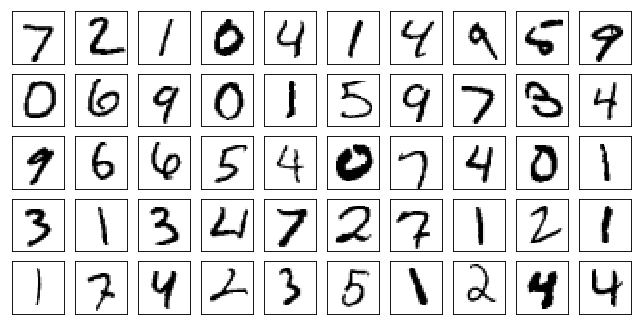

[tensor(7), tensor(2), tensor(1), tensor(0), tensor(4), tensor(1), tensor(4), tensor(9), tensor(5), tensor(9), tensor(0), tensor(6), tensor(9), tensor(0), tensor(1), tensor(5), tensor(9), tensor(7), tensor(3), tensor(4), tensor(9), tensor(6), tensor(6), tensor(5), tensor(4), tensor(0), tensor(7), tensor(4), tensor(0), tensor(1), tensor(3), tensor(1), tensor(3), tensor(4), tensor(7), tensor(2), tensor(7), tensor(1), tensor(2), tensor(1), tensor(1), tensor(7), tensor(4), tensor(2), tensor(3), tensor(5), tensor(1), tensor(2), tensor(4), tensor(4)]


In [24]:
data, _ = next(iter(test_loader))
output = model.forward(data)
predictions = [output[i].argmax() for i in range(50)]
plot_mnist(data.data.numpy(), (5, 10))

print (predictions)

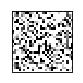

In [25]:
data, _ = next(iter(test_loader))
img = torch.randn((1, 784)).view(-1, 1, 28, 28)
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (1, 1))


In [26]:
from torch.autograd import Variable

def generate_image(img, cl):
    
    gen_img_par = Variable(img, requires_grad=True)       
    target = torch.ones((1), dtype=torch.long) * cl
    steps_since_lr_decreased = 0
    
    loss_stats = []    
    lr=1e-1

    for i in range(1, 1000001):  
                
        out = model.forward(gen_img_par)      
                 
        gen_optim = optim.RMSprop([gen_img_par], lr=lr, weight_decay=0.)    
        gen_optim.zero_grad()
        loss = F.cross_entropy(out, target) 
        loss.backward()                   
        gen_optim.step()
        
        if i % 5000 == 0:    
            print ("Iteration {}: loss={} prediction={} lr={}".format(i,loss, out.argmax(), lr))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
            
            #print("PRED=", out.argmax())
            #print("OUT=", out)
            #print("TR=", target)
                        
            if len(loss_stats) > 10:    
                down = False    
                for k in range(2, 7):    
                    if ls < loss_stats[-k]:
                        down = True
                        break
                # Loss is rising for 5 last epochs - decrease LR
                if not down and steps_since_lr_decreased > 10:
                    lr = lr * 0.5
                    steps_since_lr_decreased = 0
                    print ("Decreasing LR ..")
                    if lr < 1e-7:
                        print ("Stop ..")
                        break
                
                steps_since_lr_decreased += 1


        if i % 50000 == 0:
            to_plot = gen_img_par.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (1, 1))
                        
    return gen_img_par, loss_stats      


Iteration 5000: loss=1.3160583733906606e-12 prediction=6 lr=0.1
Iteration 10000: loss=6.588063428125679e-13 prediction=6 lr=0.1
Iteration 15000: loss=4.39870362356487e-13 prediction=6 lr=0.1
Iteration 20000: loss=3.2929214910382143e-13 prediction=6 lr=0.1
Iteration 25000: loss=2.6290081223123707e-13 prediction=6 lr=0.1
Iteration 30000: loss=2.1893598045608087e-13 prediction=6 lr=0.1
Iteration 35000: loss=1.8762769116165146e-13 prediction=6 lr=0.1
Iteration 40000: loss=1.638689184346731e-13 prediction=6 lr=0.1
Iteration 45000: loss=1.4566126083082054e-13 prediction=6 lr=0.1
Iteration 50000: loss=1.3100631690576847e-13 prediction=6 lr=0.1


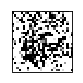

Iteration 55000: loss=1.1901590823981678e-13 prediction=6 lr=0.1
Iteration 60000: loss=1.0946799022804043e-13 prediction=6 lr=0.1
Iteration 65000: loss=1.0125233984581428e-13 prediction=6 lr=0.1
Iteration 70000: loss=9.414691248821327e-14 prediction=6 lr=0.1
Iteration 75000: loss=8.815170815523743e-14 prediction=6 lr=0.1
Iteration 80000: loss=8.260059303211165e-14 prediction=6 lr=0.1
Iteration 85000: loss=7.793765632868599e-14 prediction=6 lr=0.1
Iteration 90000: loss=7.394085344003543e-14 prediction=6 lr=0.1
Iteration 95000: loss=7.016609515630989e-14 prediction=6 lr=0.1
Iteration 100000: loss=6.661338147750939e-14 prediction=6 lr=0.1


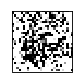

Iteration 105000: loss=6.350475700855895e-14 prediction=6 lr=0.1
Iteration 110000: loss=6.084022174945858e-14 prediction=6 lr=0.1
Iteration 115000: loss=5.81756864903582e-14 prediction=6 lr=0.1
Iteration 120000: loss=5.595524044110789e-14 prediction=6 lr=0.1
Iteration 125000: loss=5.3734794391857577e-14 prediction=6 lr=0.1
Iteration 130000: loss=5.1736392947532295e-14 prediction=6 lr=0.1
Iteration 135000: loss=4.9960036108132044e-14 prediction=6 lr=0.1
Iteration 140000: loss=4.8183679268731794e-14 prediction=6 lr=0.1
Iteration 145000: loss=4.6629367034256575e-14 prediction=6 lr=0.1
Iteration 150000: loss=4.529709940470639e-14 prediction=6 lr=0.1


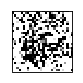

Iteration 155000: loss=4.39648317751562e-14 prediction=6 lr=0.1
Iteration 160000: loss=4.263256414560601e-14 prediction=6 lr=0.1
Iteration 165000: loss=4.1522341120980855e-14 prediction=6 lr=0.1
Iteration 170000: loss=4.063416270128073e-14 prediction=6 lr=0.1
Iteration 175000: loss=3.952393967665557e-14 prediction=6 lr=0.1
Iteration 180000: loss=3.863576125695545e-14 prediction=6 lr=0.1
Iteration 185000: loss=3.774758283725532e-14 prediction=6 lr=0.1
Iteration 190000: loss=3.68594044175552e-14 prediction=6 lr=0.1
Iteration 195000: loss=3.6193270602780103e-14 prediction=6 lr=0.1
Iteration 200000: loss=3.552713678800501e-14 prediction=6 lr=0.1


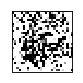

Iteration 205000: loss=3.4861002973229915e-14 prediction=6 lr=0.1
Iteration 210000: loss=3.419486915845482e-14 prediction=6 lr=0.1
Iteration 215000: loss=3.352873534367973e-14 prediction=6 lr=0.1
Iteration 220000: loss=3.3084646133829665e-14 prediction=6 lr=0.1
Iteration 225000: loss=3.241851231905457e-14 prediction=6 lr=0.1
Iteration 230000: loss=3.197442310920451e-14 prediction=6 lr=0.1
Iteration 235000: loss=3.1530333899354446e-14 prediction=6 lr=0.1
Iteration 240000: loss=3.086420008457935e-14 prediction=6 lr=0.1
Iteration 245000: loss=3.042011087472929e-14 prediction=6 lr=0.1
Iteration 250000: loss=2.9976021664879227e-14 prediction=6 lr=0.1


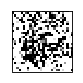

Iteration 255000: loss=2.9531932455029164e-14 prediction=6 lr=0.1
Iteration 260000: loss=2.90878432451791e-14 prediction=6 lr=0.1
Iteration 265000: loss=2.864375403532904e-14 prediction=6 lr=0.1
Iteration 270000: loss=2.8199664825478976e-14 prediction=6 lr=0.1
Iteration 275000: loss=2.7977620220553945e-14 prediction=6 lr=0.1
Iteration 280000: loss=2.7533531010703882e-14 prediction=6 lr=0.1
Iteration 285000: loss=2.708944180085382e-14 prediction=6 lr=0.1
Iteration 290000: loss=2.6867397195928788e-14 prediction=6 lr=0.1
Iteration 295000: loss=2.6423307986078726e-14 prediction=6 lr=0.1
Iteration 300000: loss=2.6201263381153694e-14 prediction=6 lr=0.1


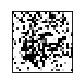

Iteration 305000: loss=2.5757174171303632e-14 prediction=6 lr=0.1
Iteration 310000: loss=2.55351295663786e-14 prediction=6 lr=0.1
Iteration 315000: loss=2.531308496145357e-14 prediction=6 lr=0.1
Iteration 320000: loss=2.4868995751603507e-14 prediction=6 lr=0.1
Iteration 325000: loss=2.4646951146678475e-14 prediction=6 lr=0.1
Iteration 330000: loss=2.4424906541753444e-14 prediction=6 lr=0.1
Iteration 335000: loss=2.4202861936828413e-14 prediction=6 lr=0.1
Iteration 340000: loss=2.398081733190338e-14 prediction=6 lr=0.1
Iteration 345000: loss=2.353672812205332e-14 prediction=6 lr=0.1
Iteration 350000: loss=2.3314683517128287e-14 prediction=6 lr=0.1


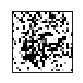

Iteration 355000: loss=2.3314683517128287e-14 prediction=6 lr=0.1
Iteration 360000: loss=2.3092638912203256e-14 prediction=6 lr=0.1
Iteration 365000: loss=2.2870594307278225e-14 prediction=6 lr=0.1
Iteration 370000: loss=2.2648549702353193e-14 prediction=6 lr=0.1
Iteration 375000: loss=2.2426505097428162e-14 prediction=6 lr=0.1
Iteration 380000: loss=2.220446049250313e-14 prediction=6 lr=0.1
Iteration 385000: loss=2.19824158875781e-14 prediction=6 lr=0.1
Iteration 390000: loss=2.1760371282653068e-14 prediction=6 lr=0.1
Iteration 395000: loss=2.1760371282653068e-14 prediction=6 lr=0.1
Iteration 400000: loss=2.1538326677728037e-14 prediction=6 lr=0.1


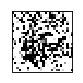

Iteration 405000: loss=2.1316282072803006e-14 prediction=6 lr=0.1
Iteration 410000: loss=2.1094237467877974e-14 prediction=6 lr=0.1
Iteration 415000: loss=2.0872192862952943e-14 prediction=6 lr=0.1
Iteration 420000: loss=2.0872192862952943e-14 prediction=6 lr=0.1
Iteration 425000: loss=2.0650148258027912e-14 prediction=6 lr=0.1
Iteration 430000: loss=2.042810365310288e-14 prediction=6 lr=0.1
Iteration 435000: loss=2.042810365310288e-14 prediction=6 lr=0.1
Iteration 440000: loss=2.020605904817785e-14 prediction=6 lr=0.1
Iteration 445000: loss=1.9984014443252818e-14 prediction=6 lr=0.1
Iteration 450000: loss=1.9984014443252818e-14 prediction=6 lr=0.1


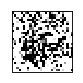

Iteration 455000: loss=1.9761969838327786e-14 prediction=6 lr=0.1
Iteration 460000: loss=1.9539925233402755e-14 prediction=6 lr=0.1
Iteration 465000: loss=1.9539925233402755e-14 prediction=6 lr=0.1
Iteration 470000: loss=1.9317880628477724e-14 prediction=6 lr=0.1
Iteration 475000: loss=1.9095836023552692e-14 prediction=6 lr=0.1
Iteration 480000: loss=1.9095836023552692e-14 prediction=6 lr=0.1
Iteration 485000: loss=1.887379141862766e-14 prediction=6 lr=0.1
Iteration 490000: loss=1.887379141862766e-14 prediction=6 lr=0.1
Iteration 495000: loss=1.865174681370263e-14 prediction=6 lr=0.1
Iteration 500000: loss=1.865174681370263e-14 prediction=6 lr=0.1


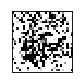

Iteration 505000: loss=1.84297022087776e-14 prediction=6 lr=0.1
Iteration 510000: loss=1.84297022087776e-14 prediction=6 lr=0.1
Iteration 515000: loss=1.8207657603852567e-14 prediction=6 lr=0.1
Iteration 520000: loss=1.8207657603852567e-14 prediction=6 lr=0.1
Iteration 525000: loss=1.7985612998927536e-14 prediction=6 lr=0.1
Iteration 530000: loss=1.7985612998927536e-14 prediction=6 lr=0.1
Iteration 535000: loss=1.7763568394002505e-14 prediction=6 lr=0.1
Iteration 540000: loss=1.7763568394002505e-14 prediction=6 lr=0.1
Iteration 545000: loss=1.7763568394002505e-14 prediction=6 lr=0.1
Iteration 550000: loss=1.7541523789077473e-14 prediction=6 lr=0.1


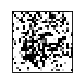

Iteration 555000: loss=1.7541523789077473e-14 prediction=6 lr=0.1
Iteration 560000: loss=1.7319479184152442e-14 prediction=6 lr=0.1
Iteration 565000: loss=1.7319479184152442e-14 prediction=6 lr=0.1
Iteration 570000: loss=1.709743457922741e-14 prediction=6 lr=0.1
Iteration 575000: loss=1.709743457922741e-14 prediction=6 lr=0.1
Iteration 580000: loss=1.709743457922741e-14 prediction=6 lr=0.1
Iteration 585000: loss=1.687538997430238e-14 prediction=6 lr=0.1
Iteration 590000: loss=1.687538997430238e-14 prediction=6 lr=0.1
Iteration 595000: loss=1.6653345369377348e-14 prediction=6 lr=0.1
Iteration 600000: loss=1.6653345369377348e-14 prediction=6 lr=0.1


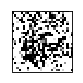

Iteration 605000: loss=1.6653345369377348e-14 prediction=6 lr=0.1
Iteration 610000: loss=1.6431300764452317e-14 prediction=6 lr=0.1
Iteration 615000: loss=1.6431300764452317e-14 prediction=6 lr=0.1
Iteration 620000: loss=1.6431300764452317e-14 prediction=6 lr=0.1
Iteration 625000: loss=1.6209256159527285e-14 prediction=6 lr=0.1
Iteration 630000: loss=1.6209256159527285e-14 prediction=6 lr=0.1
Iteration 635000: loss=1.6209256159527285e-14 prediction=6 lr=0.1
Iteration 640000: loss=1.5987211554602254e-14 prediction=6 lr=0.1
Iteration 645000: loss=1.5987211554602254e-14 prediction=6 lr=0.1
Iteration 650000: loss=1.5987211554602254e-14 prediction=6 lr=0.1


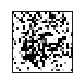

Iteration 655000: loss=1.5765166949677223e-14 prediction=6 lr=0.1
Iteration 660000: loss=1.5765166949677223e-14 prediction=6 lr=0.1
Iteration 665000: loss=1.5765166949677223e-14 prediction=6 lr=0.1
Iteration 670000: loss=1.554312234475219e-14 prediction=6 lr=0.1
Iteration 675000: loss=1.554312234475219e-14 prediction=6 lr=0.1
Iteration 680000: loss=1.554312234475219e-14 prediction=6 lr=0.1
Iteration 685000: loss=1.532107773982716e-14 prediction=6 lr=0.1
Iteration 690000: loss=1.532107773982716e-14 prediction=6 lr=0.1
Iteration 695000: loss=1.532107773982716e-14 prediction=6 lr=0.1
Iteration 700000: loss=1.532107773982716e-14 prediction=6 lr=0.1


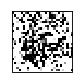

Iteration 705000: loss=1.509903313490213e-14 prediction=6 lr=0.1
Iteration 710000: loss=1.509903313490213e-14 prediction=6 lr=0.1
Iteration 715000: loss=1.509903313490213e-14 prediction=6 lr=0.1
Iteration 720000: loss=1.4876988529977098e-14 prediction=6 lr=0.1
Iteration 725000: loss=1.4876988529977098e-14 prediction=6 lr=0.1
Iteration 730000: loss=1.4876988529977098e-14 prediction=6 lr=0.1
Iteration 735000: loss=1.4876988529977098e-14 prediction=6 lr=0.1
Iteration 740000: loss=1.4654943925052066e-14 prediction=6 lr=0.1
Iteration 745000: loss=1.4654943925052066e-14 prediction=6 lr=0.1
Iteration 750000: loss=1.4654943925052066e-14 prediction=6 lr=0.1


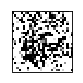

Iteration 755000: loss=1.4654943925052066e-14 prediction=6 lr=0.1
Iteration 760000: loss=1.4432899320127035e-14 prediction=6 lr=0.1
Iteration 765000: loss=1.4432899320127035e-14 prediction=6 lr=0.1
Iteration 770000: loss=1.4432899320127035e-14 prediction=6 lr=0.1
Iteration 775000: loss=1.4432899320127035e-14 prediction=6 lr=0.1
Iteration 780000: loss=1.4210854715202004e-14 prediction=6 lr=0.1
Iteration 785000: loss=1.4210854715202004e-14 prediction=6 lr=0.1
Iteration 790000: loss=1.4210854715202004e-14 prediction=6 lr=0.1
Iteration 795000: loss=1.4210854715202004e-14 prediction=6 lr=0.1
Iteration 800000: loss=1.4210854715202004e-14 prediction=6 lr=0.1


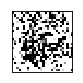

Iteration 805000: loss=1.3988810110276972e-14 prediction=6 lr=0.1
Iteration 810000: loss=1.3988810110276972e-14 prediction=6 lr=0.1
Iteration 815000: loss=1.3988810110276972e-14 prediction=6 lr=0.1
Iteration 820000: loss=1.3988810110276972e-14 prediction=6 lr=0.1
Iteration 825000: loss=1.3988810110276972e-14 prediction=6 lr=0.1
Iteration 830000: loss=1.3766765505351941e-14 prediction=6 lr=0.1
Iteration 835000: loss=1.3766765505351941e-14 prediction=6 lr=0.1
Iteration 840000: loss=1.3766765505351941e-14 prediction=6 lr=0.1
Iteration 845000: loss=1.3766765505351941e-14 prediction=6 lr=0.1
Iteration 850000: loss=1.3766765505351941e-14 prediction=6 lr=0.1


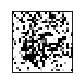

Iteration 855000: loss=1.3766765505351941e-14 prediction=6 lr=0.1
Decreasing LR ..
Iteration 860000: loss=1.354472090042691e-14 prediction=6 lr=0.05
Iteration 865000: loss=1.354472090042691e-14 prediction=6 lr=0.05
Iteration 870000: loss=1.354472090042691e-14 prediction=6 lr=0.05
Iteration 875000: loss=1.354472090042691e-14 prediction=6 lr=0.05
Iteration 880000: loss=1.354472090042691e-14 prediction=6 lr=0.05
Iteration 885000: loss=1.354472090042691e-14 prediction=6 lr=0.05
Iteration 890000: loss=1.354472090042691e-14 prediction=6 lr=0.05
Iteration 895000: loss=1.354472090042691e-14 prediction=6 lr=0.05
Iteration 900000: loss=1.354472090042691e-14 prediction=6 lr=0.05


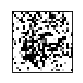

Iteration 905000: loss=1.354472090042691e-14 prediction=6 lr=0.05
Iteration 910000: loss=1.354472090042691e-14 prediction=6 lr=0.05
Decreasing LR ..
Iteration 915000: loss=1.354472090042691e-14 prediction=6 lr=0.025
Iteration 920000: loss=1.354472090042691e-14 prediction=6 lr=0.025
Iteration 925000: loss=1.354472090042691e-14 prediction=6 lr=0.025
Iteration 930000: loss=1.354472090042691e-14 prediction=6 lr=0.025
Iteration 935000: loss=1.354472090042691e-14 prediction=6 lr=0.025
Iteration 940000: loss=1.354472090042691e-14 prediction=6 lr=0.025
Iteration 945000: loss=1.354472090042691e-14 prediction=6 lr=0.025
Iteration 950000: loss=1.354472090042691e-14 prediction=6 lr=0.025


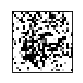

Iteration 955000: loss=1.354472090042691e-14 prediction=6 lr=0.025
Iteration 960000: loss=1.354472090042691e-14 prediction=6 lr=0.025
Iteration 965000: loss=1.354472090042691e-14 prediction=6 lr=0.025
Decreasing LR ..
Iteration 970000: loss=1.354472090042691e-14 prediction=6 lr=0.0125
Iteration 975000: loss=1.354472090042691e-14 prediction=6 lr=0.0125
Iteration 980000: loss=1.354472090042691e-14 prediction=6 lr=0.0125
Iteration 985000: loss=1.354472090042691e-14 prediction=6 lr=0.0125
Iteration 990000: loss=1.354472090042691e-14 prediction=6 lr=0.0125
Iteration 995000: loss=1.354472090042691e-14 prediction=6 lr=0.0125
Iteration 1000000: loss=1.354472090042691e-14 prediction=6 lr=0.0125


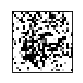

In [27]:
new_image_randn = generate_image(img, 6)